In [18]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

#from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
np.set_printoptions(suppress=True)

/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:781: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=[])
/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:1364: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=spec)
/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:1560: NumbaDeprecationWarning: The 'numba.jitclass' decorator 

### Start with definition and training of the DNN at the bottom of this NB

# C&W L2 Attack

$F(x) = y$  neural network<br>
$F$  model<br>
$x$  input<br>
$y$  output<br>
$m$  amount of classes<br>

$C(x)$  label assigned by model =arg max F(x)<br>
$C*(x)$  correct label<br>
$Z(x) = z$  logits -> output of all layers except softmax<br>

$F(x)$ = $softmax(Z(x))$ = $y$<br>
$F$ = $softmax ◦ F_n ◦ F_n-1 ◦ ... ◦ F_1$  A network consists of layers $F_n$<br>
$F_i(x)$ = $\sigma$ * $(\Theta_i * x)$ + $\hat{\Theta_i}$<br>
$\sigma$  activation function<br>
$\Theta$  Params<br>
$\hat{\Theta}$ Bias<br>

$t$  target class<br>
$x$  input<br>
$x'$ adversarial input <br>

$||x - x'||_p$ the $L_p$ distance
$|| · ||_p$  = $ || v ||_p = ( \sum_{n=1}^{n} | v_i | ^ p)^{1/p}$


# Approach
minimize $D (x, x + \delta)$ <br>
such that <br>
$C(x + \delta) = t$<br>
$x + \delta \in [0,1]$


$\delta$ change
$D$ distance metric

### Alternative Formulation
minimize $D (x, x + \delta) + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

$f(x+\delta)$ is one of the following objective functions
$c$ is a constant

### Set norm as distance measure 

minimize $||\delta||_p + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

# Objective Functions

$f_1(x) = -loss_{F,t}(x')+1$ <br>
$f_2(x) = (max(F(x')_i) - F(x')_t)^+$ <br>
$f_3(x) = softplus(max(F(x')_i) - F(x')_t) - log(2)$<br>
$f_4(x) = (0.5 - F(x')_t)^+$<br>
$f_5(x) = -log(2F(x')_t -2)$ <br>
$f_6(x) = (max(Z(x')_i) - Z(x')_t)^+$ <br>
$f_7(x) = softplus(max(Z(x')_i) - Z(x')_t) - log(2)$

$(yyy)^+ = max(yyy, o)$<br>
$softplus(yyy) = log(1+exp(yyy))$<br>
$loss_{F,t}(x)$ = cross entropy loss

## ensure box contraint
introduce an new variable $w$<br>
so<br>
$\delta_i = 1/2(tanh(w_i)+1)-x_i$

$x_i+ \delta_i \in [0,1]$ because:<br>
$-1 \leq tanh(x) \leq 1$<br>
so<br>
$0 \leq x_i+\delta_i \leq 1$

# Putting it together
###### for the l2 attack
f1 : minimize $||1/2(tanh(w_i)+1)-x_i||^2_2 +c * f(1/2(tanh(w)+1)$

with $f$ defined as:

f2 : $f(x') = $ max$($max$({Z(x')_i:i\neq t} )-Z(x')_t, -\kappa)$

In [19]:
def loss_function(x, adv_image, const, target):
    l1 = tf.square(tf.norm(adv_image - x))
    logit_of_best_other = get_logit_of_best_except_target(model, adv_image, target)
    logit_of_target = get_logit_of_target(model, adv_image,target)
    l2 = const * tf.math.maximum(
        logit_of_best_other
        - logit_of_target
        , 0 )
    return l1 + l2
    
def alternate_loss_fn(x, adv_image, const, target):
    #print('adv',adv_x)
    #print('clean', x)
    #check why the do not use norm in the cleverhans implementation

    loss1 = tf.square(tf.norm(adv_image - x))
    #loss1 = tf.square(tf.norm(adv_image - x, ord=1))
    loss2 = const * f2(adv_image, target)
    #print('losses: ',loss1.numpy(), loss2.numpy())
    #print('loss:', (loss2 + loss1).numpy())
    return loss2 + loss1
    #return loss1 + loss2

In [20]:

def f2(adv_x, target):
    logit_of_best_other = get_logit_of_best_except_target(model, adv_x, target)
    logit_of_target = get_logit_of_target(model, adv_x, target)
    
    return tf.math.maximum(logit_of_best_other - logit_of_target, 0 )

    

0
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=13.336802>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=366.08627>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5>>
target class:  2
pred of adv ex:  0


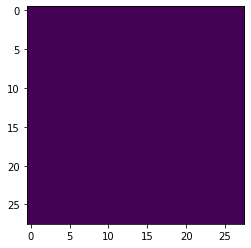

1
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=13.031251>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=357.7449>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.51499546>>
target class:  2
pred of adv ex:  0


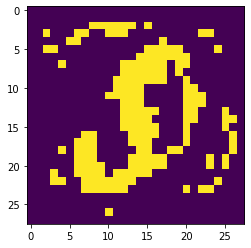

2
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=12.728459>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=349.35745>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5299796>>
target class:  2
pred of adv ex:  0


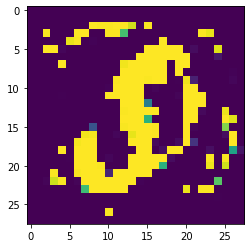

3
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=12.4358015>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=341.1122>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5448931>>
target class:  2
pred of adv ex:  0


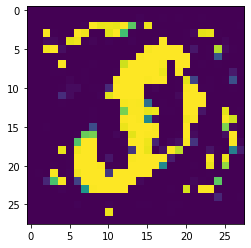

4
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=12.160497>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=333.1737>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5597989>>
target class:  2
pred of adv ex:  2


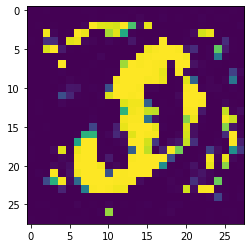

5
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=11.846388>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=324.22784>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.56856406>>
target class:  2
pred of adv ex:  2


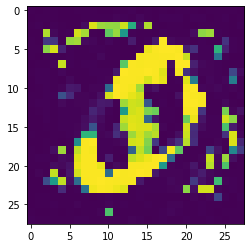

6
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=11.51919>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=314.94446>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.57325387>>
target class:  2
pred of adv ex:  2


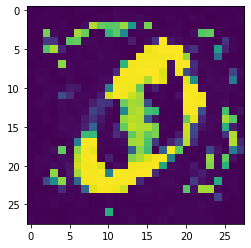

7
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=11.186222>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=305.49902>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.57478285>>
target class:  2
pred of adv ex:  2


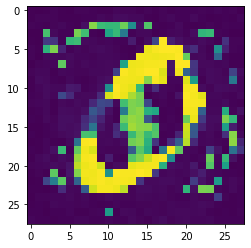

8
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=10.851455>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=296.00058>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5738705>>
target class:  2
pred of adv ex:  2


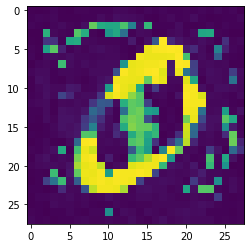

9
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=10.517509>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=286.52493>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5710195>>
target class:  2
pred of adv ex:  2


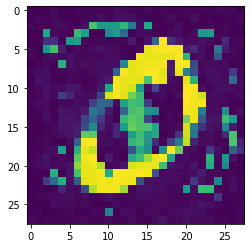

10
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=10.186296>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=277.1277>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.56659484>>
target class:  2
pred of adv ex:  2


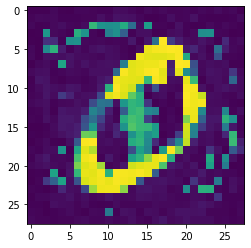

11
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=9.859312>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=267.85635>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.560871>>
target class:  2
pred of adv ex:  2


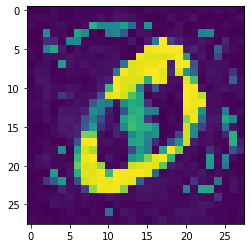

12
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=9.5377655>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=258.75>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5540608>>
target class:  2
pred of adv ex:  2


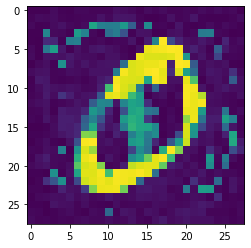

13
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=9.222659>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=249.82886>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5463344>>
target class:  2
pred of adv ex:  2


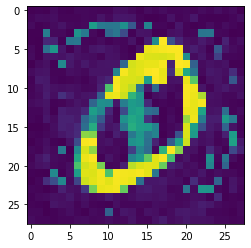

14
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=8.914825>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=241.1175>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5378315>>
target class:  2
pred of adv ex:  2


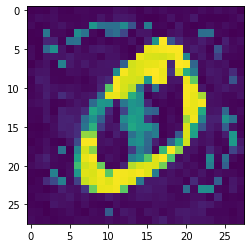

15
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=8.614956>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=232.64517>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5286701>>
target class:  2
pred of adv ex:  2


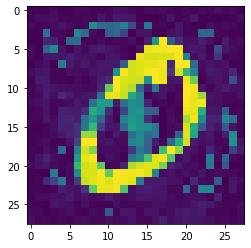

16
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=8.323616>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=224.43509>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.5189519>>
target class:  2
pred of adv ex:  2


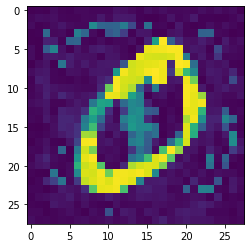

17
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=8.04126>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=216.50388>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.50876665>>
target class:  2
pred of adv ex:  2


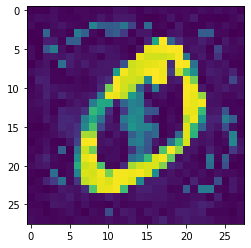

18
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=7.7682366>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=208.83923>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.49819505>>
target class:  2
pred of adv ex:  0


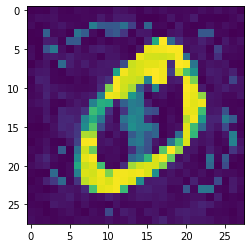

19
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=7.5216117>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=201.91068>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.49178064>>
target class:  2
pred of adv ex:  0


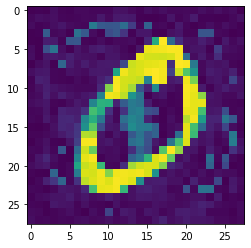

20
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=7.299212>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=195.61325>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.489338>>
target class:  2
pred of adv ex:  0


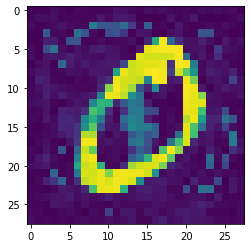

21
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=7.0988374>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=189.87906>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.48992386>>
target class:  2
pred of adv ex:  2


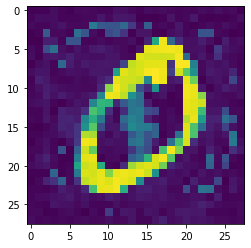

22
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.904156>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=184.34558>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.48923835>>
target class:  2
pred of adv ex:  2


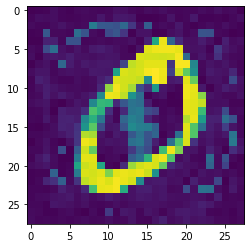

23
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.7150598>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=179.01532>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.4874119>>
target class:  2
pred of adv ex:  2


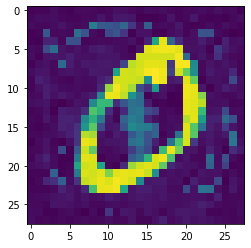

24
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.53146>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=173.85533>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.48456314>>
target class:  2
pred of adv ex:  2


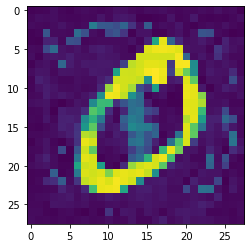

25
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.353286>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=168.86563>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.4808004>>
target class:  2
pred of adv ex:  2


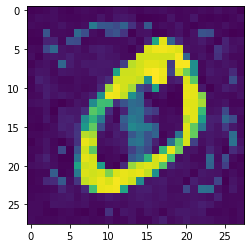

26
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.180476>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=164.05115>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.47622287>>
target class:  2
pred of adv ex:  2


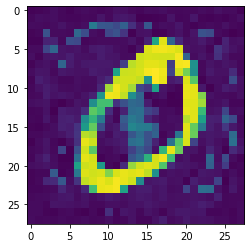

27
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=6.012981>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=159.40326>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.47092193>>
target class:  2
pred of adv ex:  2


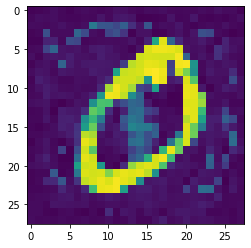

28
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.8507533>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=154.92725>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.46498203>>
target class:  2
pred of adv ex:  2


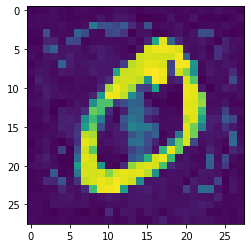

29
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.6937504>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=150.61606>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.4584816>>
target class:  2
pred of adv ex:  2


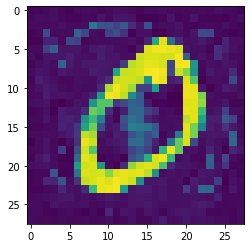

30
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.5419292>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=146.46649>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.45149386>>
target class:  2
pred of adv ex:  2


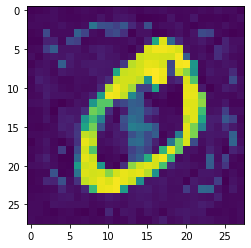

31
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.3952465>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=142.47162>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.44408715>>
target class:  2
pred of adv ex:  0


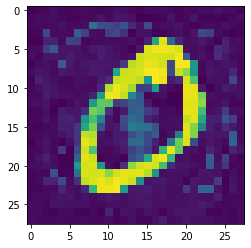

32
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.2680693>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=138.96658>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.43938464>>
target class:  2
pred of adv ex:  0


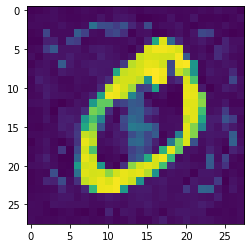

33
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.1584806>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=135.89763>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.4370574>>
target class:  2
pred of adv ex:  2


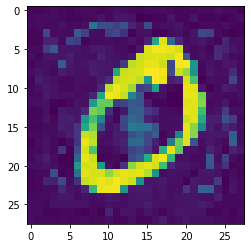

34
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=5.0513754>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=132.94705>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.43391103>>
target class:  2
pred of adv ex:  2


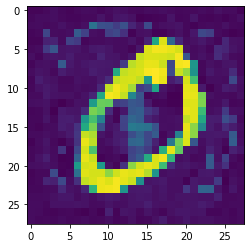

35
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.9466124>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=130.07552>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.43003199>>
target class:  2
pred of adv ex:  2


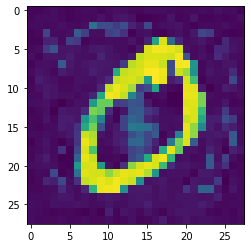

36
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.844102>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=127.278>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.42550164>>
target class:  2
pred of adv ex:  2


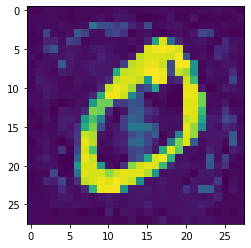

37
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.743793>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=124.54921>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.42039645>>
target class:  2
pred of adv ex:  2


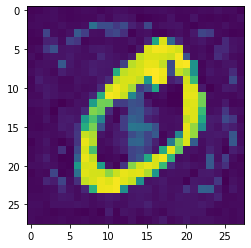

38
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.6456647>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=121.890945>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.41478834>>
target class:  2
pred of adv ex:  2


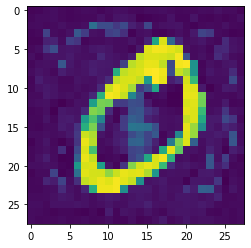

39
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.549719>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=119.30484>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.40874478>>
target class:  2
pred of adv ex:  0


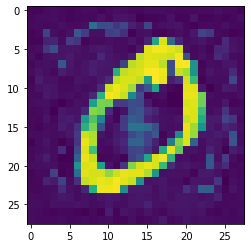

40
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.470774>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=117.12305>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.40537605>>
target class:  2
pred of adv ex:  2


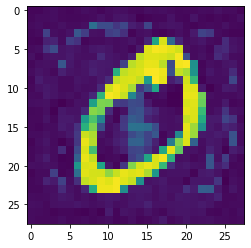

41
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.392717>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=114.986206>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.4013877>>
target class:  2
pred of adv ex:  2


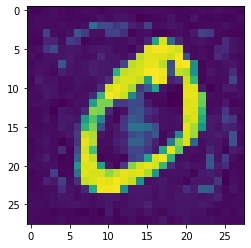

42
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.315541>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=112.885666>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3972052>>
target class:  2
pred of adv ex:  0


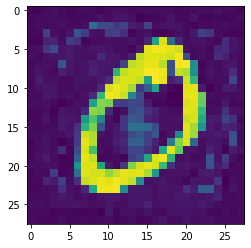

43
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.253386>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=111.134056>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.39715326>>
target class:  2
pred of adv ex:  2


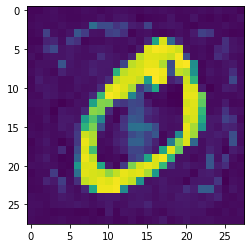

44
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.191012>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=109.394>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3962413>>
target class:  2
pred of adv ex:  2


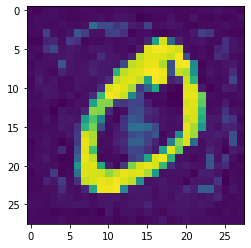

45
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.128422>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=107.66365>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.39454934>>
target class:  2
pred of adv ex:  2


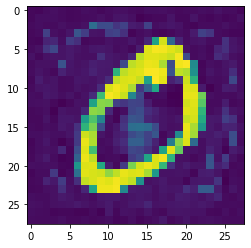

46
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.0656676>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=105.94829>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3921539>>
target class:  2
pred of adv ex:  2


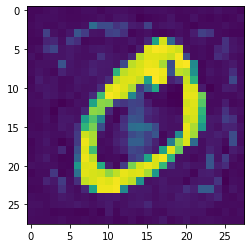

47
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=4.0028334>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=104.24735>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.38912773>>
target class:  2
pred of adv ex:  2


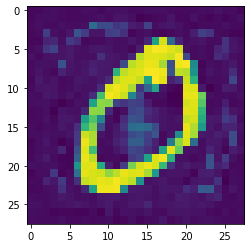

48
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.9400299>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=102.563416>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.38553992>>
target class:  2
pred of adv ex:  2


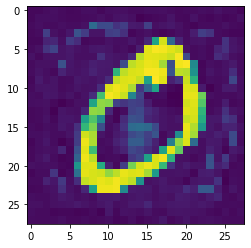

49
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.8773856>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=100.898056>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.38145578>>
target class:  2
pred of adv ex:  0


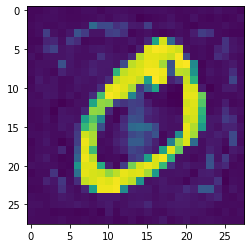

50
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.8294222>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=99.56621>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.37982807>>
target class:  2
pred of adv ex:  2


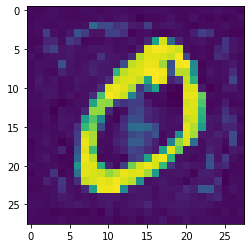

51
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.7805338>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=98.221725>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.37753502>>
target class:  2
pred of adv ex:  2


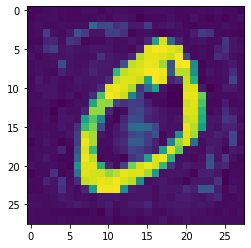

52
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.7308385>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=96.8681>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3746462>>
target class:  2
pred of adv ex:  2


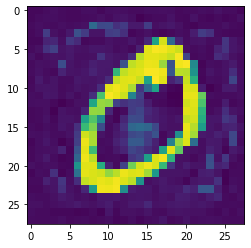

53
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.6804783>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=95.50874>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.37122774>>
target class:  2
pred of adv ex:  0


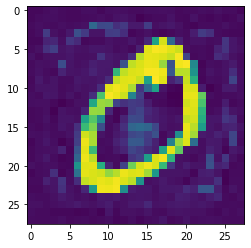

54
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.6441088>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=94.4597>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.37018397>>
target class:  2
pred of adv ex:  2


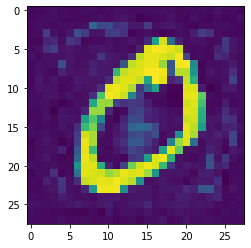

55
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.6060915>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=93.382355>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.368449>>
target class:  2
pred of adv ex:  2


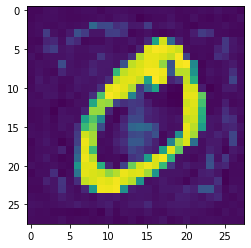

56
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.5665557>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=92.27933>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.36609277>>
target class:  2
pred of adv ex:  2


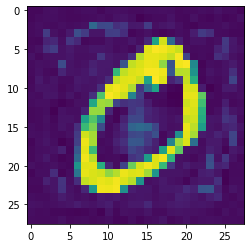

57
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.5256634>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=91.15487>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3631819>>
target class:  2
pred of adv ex:  2


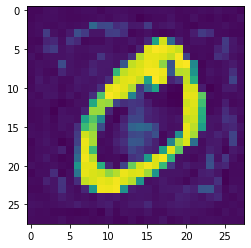

58
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.4835954>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=90.0132>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.35977948>>
target class:  2
pred of adv ex:  2


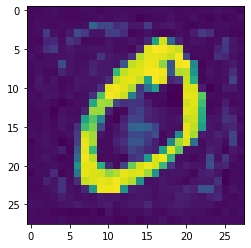

59
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.4405458>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=88.85906>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.35594523>>
target class:  2
pred of adv ex:  0


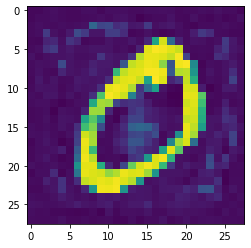

60
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.4115584>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=88.01251>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.35453296>>
target class:  2
pred of adv ex:  2


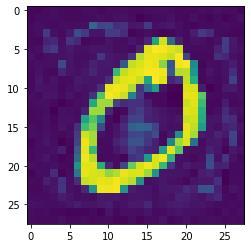

61
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.3805647>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=87.13118>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.35251284>>
target class:  2
pred of adv ex:  2


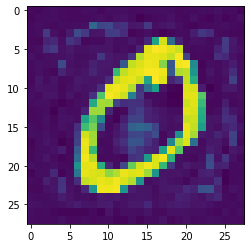

62
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.3477416>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=86.21875>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34994927>>
target class:  2
pred of adv ex:  2


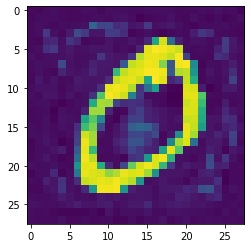

63
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.3132906>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=85.279625>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34690338>>
target class:  2
pred of adv ex:  2


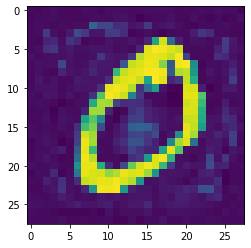

64
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.2774234>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=84.31738>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3436761>>
target class:  2
pred of adv ex:  0


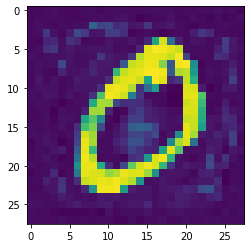

65
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.2560544>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=83.65775>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34399268>>
target class:  2
pred of adv ex:  2


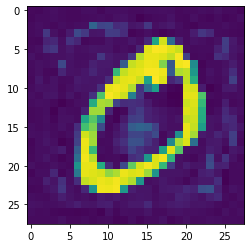

66
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.2322168>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=82.95095>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34357697>>
target class:  2
pred of adv ex:  2


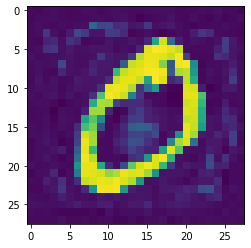

67
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.206109>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=82.20213>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34249687>>
target class:  2
pred of adv ex:  2


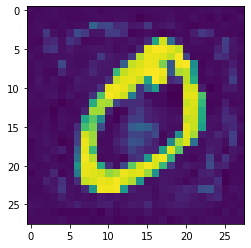

68
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.1779506>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=81.416374>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.34081784>>
target class:  2
pred of adv ex:  2


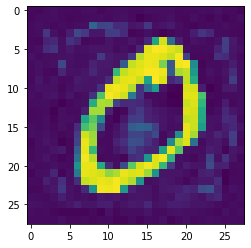

69
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.1479745>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=80.598694>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3386024>>
target class:  2
pred of adv ex:  0


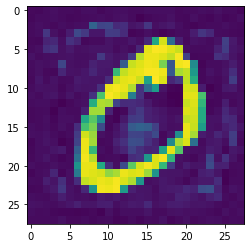

70
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.1326287>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=80.07977>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33938393>>
target class:  2
pred of adv ex:  2


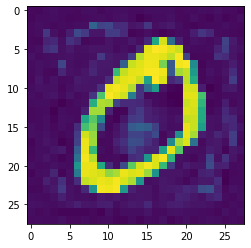

71
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.114422>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=79.51027>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33940876>>
target class:  2
pred of adv ex:  2


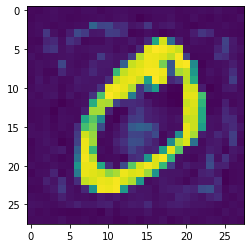

72
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.0935693>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=78.89484>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.338745>>
target class:  2
pred of adv ex:  2


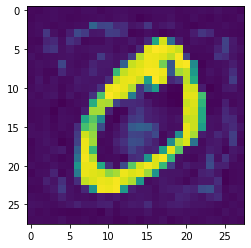

73
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.0703077>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=78.237045>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33745855>>
target class:  2
pred of adv ex:  2


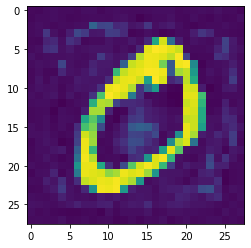

74
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.0448887>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=77.54198>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33561242>>
target class:  2
pred of adv ex:  2


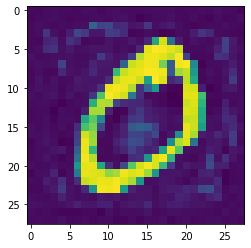

75
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=3.0175695>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=76.81484>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33326682>>
target class:  2
pred of adv ex:  2


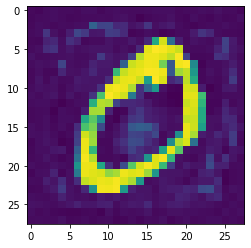

76
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.9886084>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=76.05814>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3304788>>
target class:  2
pred of adv ex:  0


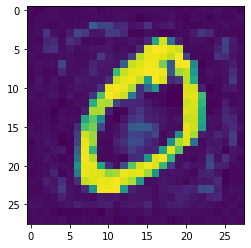

77
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.9754536>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=75.62456>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3308313>>
target class:  2
pred of adv ex:  0


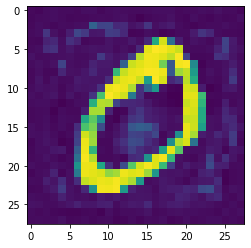

78
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.976382>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=75.471695>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3338444>>
target class:  2
pred of adv ex:  2


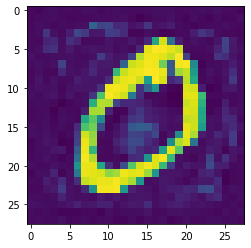

79
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.973327>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=75.238396>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33592805>>
target class:  2
pred of adv ex:  2


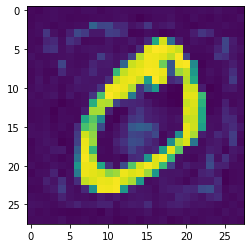

80
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.9664598>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=74.930145>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.337154>>
target class:  2
pred of adv ex:  2


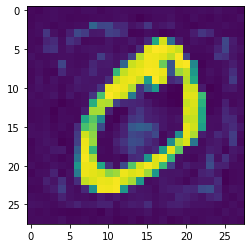

81
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.9560034>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=74.552536>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33759317>>
target class:  2
pred of adv ex:  2


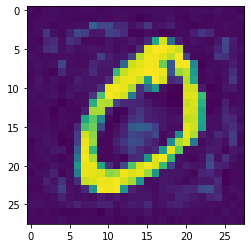

82
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.9422174>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=74.112656>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3373149>>
target class:  2
pred of adv ex:  2


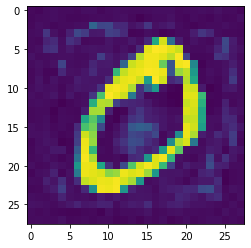

83
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.925386>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=73.61769>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33638632>>
target class:  2
pred of adv ex:  2


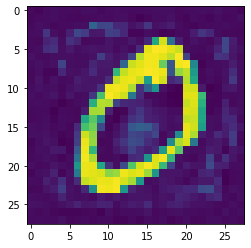

84
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.905807>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=73.07306>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33487183>>
target class:  2
pred of adv ex:  2


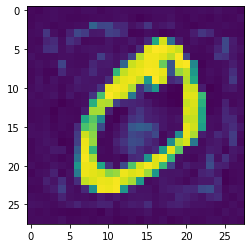

85
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.8837864>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=72.48413>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.33283302>>
target class:  2
pred of adv ex:  2


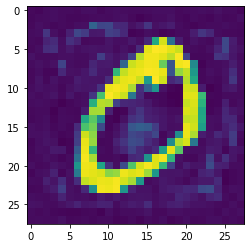

86
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.8596275>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=71.856064>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3303283>>
target class:  2
pred of adv ex:  2


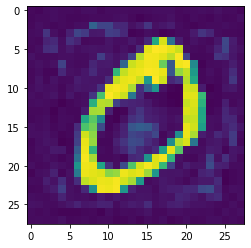

87
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.833628>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=71.19527>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32741278>>
target class:  2
pred of adv ex:  2


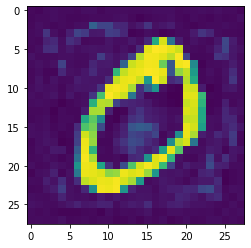

88
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.8060749>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=70.5061>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32413828>>
target class:  2
pred of adv ex:  2


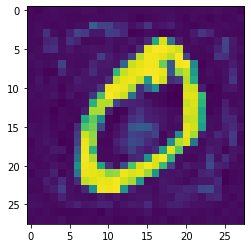

89
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.777241>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=69.79345>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32055333>>
target class:  2
pred of adv ex:  0


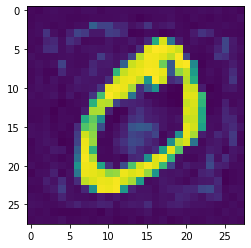

90
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.764508>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=69.405106>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3199717>>
target class:  2
pred of adv ex:  0


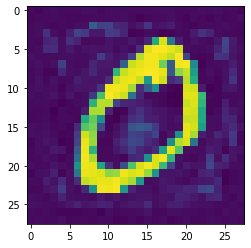

91
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7664604>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=69.31369>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32204488>>
target class:  2
pred of adv ex:  2


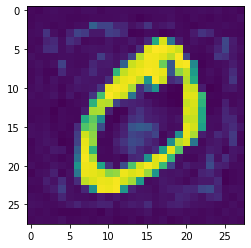

92
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7645092>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=69.14436>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32330805>>
target class:  2
pred of adv ex:  2


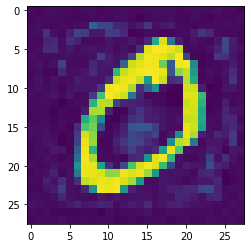

93
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7588758>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=68.90361>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32382816>>
target class:  2
pred of adv ex:  2


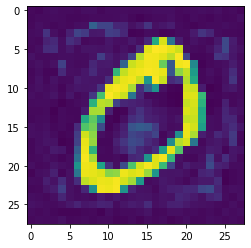

94
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7498167>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=68.598816>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3236705>>
target class:  2
pred of adv ex:  2


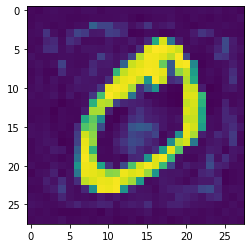

95
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7376103>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=68.23421>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32289857>>
target class:  2
pred of adv ex:  2


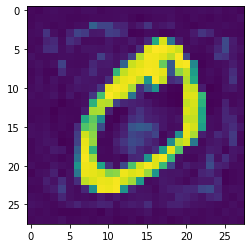

96
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7225504>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=67.81629>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.32157314>>
target class:  2
pred of adv ex:  2


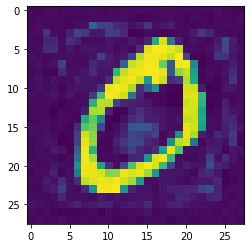

97
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.7049353>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=67.35022>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.31975237>>
target class:  2
pred of adv ex:  2


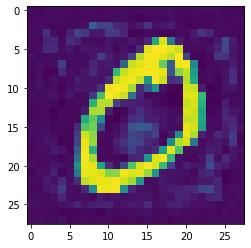

98
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.685064>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=66.84175>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.31749135>>
target class:  2
pred of adv ex:  2


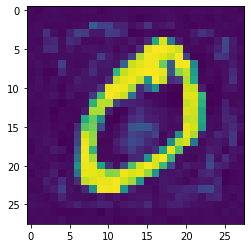

99
l2 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.6632295>>
l1 dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=66.29644>>
l_inf dist: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.3148421>>
target class:  2
pred of adv ex:  2


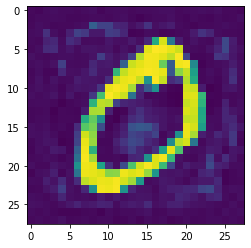

In [21]:
x = tf.convert_to_tensor(tf.expand_dims(x_train[1], axis=0), tf.float32)
w = tf.Variable(initial_value=tf.zeros(x.shape))
#print(modifier)
show_adv = []
optimizer = tf.keras.optimizers.Adam(.03)
target = find_second_most_probable_class(get_logits(model,x))
#target = 1
for i in range(100):
    print(i)
    with tf.GradientTape() as tape:
        #tape.watch(w)
        adv_image = .5 * (tf.tanh(w) + 1)
        #print(show_adv)
        preds = model(adv_image)
        const= 1
        loss = loss_function(x=x, adv_image=adv_image, const=const, target=target)
        l2_distance = tf.norm(adv_image - x).numpy
        linf_distance = tf.norm(adv_image - x, ord=np.inf).numpy
        l1_distance = tf.norm(adv_image - x, ord=1).numpy
        
        #loss = alternate_loss_fn(adv_image, x)
        #print(loss)
        grads = tape.gradient(loss, w)
        optimizer.apply_gradients([(grads, w)])
        #print(modifier)
        #print('loss:',loss.numpy())
        #print('clean',np.argmax(model(x)))
        print('l2 dist:', l2_distance)
        print('l1 dist:', l1_distance)
        print('l_inf dist:', linf_distance)
        print('target class: ',target)
        print('pred of adv ex: ',np.argmax(model(adv_image)))
        #print('adv',tf.nn.softmax(model(adv_image)))
        #print(adv_image)
        plt.figure()
        plt.imshow(tf.reshape(adv_image, (28,28)))
        plt.show()
        #show_adv = adv_image
        #print('pred:',np.argmax(tf.nn.softmax(model(adv_image))))#
        #print(show_adv)
#print(show_adv)
#plt.show()
    

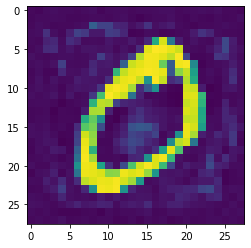

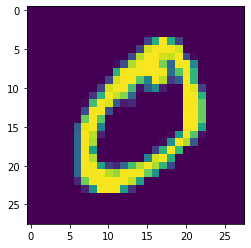

In [24]:
plt.figure()
plt.imshow(tf.reshape(adv_image, (28,28)))
plt.show()
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [25]:
w = tf.Variable(initial_value=tf.zeros(x.shape))
x = tf.convert_to_tensor(tf.expand_dims(x_train[3], axis=0), tf.float32)

In [12]:
#
def to_attack_space(x, clip_max = 1, clip_min = 0):
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    x = (x - a) / b # from (min, max) to (-1, 1)
    x = x * 0.9999999 #from (-1, 1) to ~(-1, 1)
    return tf.atanh(x) # from ~(-1, 1) to (-inf, inf)

def to_model_space(x, clip_max = 1, clip_min = 0):
    x = tf.tanh(x) # from (-inf, +inf) to (-1, 1)
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    return x * b + a # from (-1, 1) to (clip_min, clip_max), (0, 1) mostly

def clip_tanh(x, clip_min, clip_max):
    x = (tf.tanh(x) + 1) / 2
    return x * (self.clip_max - self.clip_min) + self.clip_min

def find_second_most_probable_class(logits):
    logits = logits.numpy().flatten()
    return np.argpartition(logits,len(logits)-2)[len(logits)-2]

        


In [13]:
def get_least_probable(model, x):
    all_logits = get_logits(model, x)
    #print(all_logits)
    return tf.math.argmin(all_logits)


def get_logit_of_best_except_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    #print('all_logits', all_logits)
    most_probable_class = tf.math.argmax(all_logits)
    second_most_probable_class = find_second_most_probable_class(all_logits)
    if target == most_probable_class: 
        return all_logits[second_most_probable_class ]
    if target != most_probable_class: 
        return all_logits[most_probable_class ]

def get_logit_of_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    return all_logits[target]



• Average Case: select the target class uniformly at random
among the labels that are not the correct label. <br>
• Best Case: perform the attack against all incorrect classes,
and report the target class that was least difficult to attack. <br>
• Worst Case: perform the attack against all incorrect
classes, and report the target class that was most difficult
to attack.

In [14]:
def get_logits(model, x):
    
    model(x)
    
    return model.pre_softmax[0]
    

In [27]:
def attack_step(x, y, modifier, const = 0):
    with tf.GradientTape as tape:
        adv_image = modifier + x
        x_new = clip_tanh(adv_image)
        preds = model(x_new)
        loss = loss_function(x=x, x_new=x_new, y_true=y, y_pred=preds, const=const)
        grads = tape.gradient(loss, adv_image)
        optimizer.apply_gradients([(grads, modifier)])
        return x_new, loss, preds



with tf.GradientTape() as tape:
    x = tf.convert_to_tensor(tf.expand_dims(x_train[4], axis=0), tf.float32)
    w = tf.Variable(initial_value=tf.zeros(x.shape))
    adv_x = .5*(tf.tanh(w) + 1)
    constant = 0
    delta = (adv_x - x)
    tape.watch(adv_x)
    tape.watch(x)
    tape.watch(delta)
    loss = loss_function(x, adv_x)
    gradient = tape.gradient(loss,w)
    boxmax = 1
    boxmin = 0
    boxmul = (boxmax - boxmin) / 2.
    boxplus = (boxmin + boxmax) / 2.
    
    newimg = tf.tanh(gradient + x) * boxmul + boxplus
    #print(tf.reshape(newimg, (28,28)))
    #print(tf.reshape(x, (28,28)))
    #print(tf.norm(x-newimg))
    
    plt.figure()
    plt.imshow(tf.reshape(x, (28,28)))
    plt.show()
    plt.figure()
    plt.imshow(tf.reshape(newimg, (28,28)))
    plt.show()

    # Get the gradients of the loss w.r.t to the input image.
    #gradient = tape.gradient(loss, adv_x)
    # Get the sign of the gradients to create the perturbation
    #print(gradient)

TypeError: loss_function() missing 2 required positional arguments: 'const' and 'target'

In [28]:
ds = tfds.load(name="imagenette", with_info=True, split=["train","validation"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

DatasetNotFoundError: Dataset imagenette not found. Available datasets:
	- abstract_reasoning
	- aflw2k3d
	- amazon_us_reviews
	- bair_robot_pushing_small
	- bigearthnet
	- binarized_mnist
	- binary_alpha_digits
	- caltech101
	- caltech_birds2010
	- caltech_birds2011
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- chexpert
	- cifar10
	- cifar100
	- cifar10_corrupted
	- clevr
	- cnn_dailymail
	- coco
	- coco2014
	- coil100
	- colorectal_histology
	- colorectal_histology_large
	- curated_breast_imaging_ddsm
	- cycle_gan
	- deep_weeds
	- definite_pronoun_resolution
	- diabetic_retinopathy_detection
	- downsampled_imagenet
	- dsprites
	- dtd
	- dummy_dataset_shared_generator
	- dummy_mnist
	- emnist
	- eurosat
	- fashion_mnist
	- flores
	- food101
	- gap
	- glue
	- groove
	- higgs
	- horses_or_humans
	- image_label_folder
	- imagenet2012
	- imagenet2012_corrupted
	- imdb_reviews
	- iris
	- kitti
	- kmnist
	- lfw
	- lm1b
	- lsun
	- mnist
	- mnist_corrupted
	- moving_mnist
	- multi_nli
	- nsynth
	- omniglot
	- open_images_v4
	- oxford_flowers102
	- oxford_iiit_pet
	- para_crawl
	- patch_camelyon
	- pet_finder
	- quickdraw_bitmap
	- resisc45
	- rock_paper_scissors
	- rock_you
	- scene_parse150
	- shapes3d
	- smallnorb
	- snli
	- so2sat
	- squad
	- stanford_dogs
	- stanford_online_products
	- starcraft_video
	- sun397
	- super_glue
	- svhn_cropped
	- ted_hrlr_translate
	- ted_multi_translate
	- tf_flowers
	- titanic
	- trivia_qa
	- uc_merced
	- ucf101
	- visual_domain_decathlon
	- voc2007
	- wikipedia
	- wmt14_translate
	- wmt15_translate
	- wmt16_translate
	- wmt17_translate
	- wmt18_translate
	- wmt19_translate
	- wmt_t2t_translate
	- wmt_translate
	- xnli
Check that:
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - dataset class is not in development, i.e. if IN_DEVELOPMENT=True
    - the module defining the dataset class is imported


In [17]:

def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))


shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)


plt.figure()
plt.imshow(z)
plt.show()

InvalidArgumentError: Input to reshape is a tensor with 784 values, but the requested shape has 150528 [Op:Reshape]

tf.Tensor(2, shape=(), dtype=int64)
(224, 224, 3)


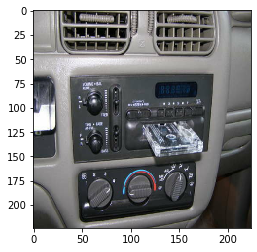

In [24]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

In [31]:
tfds.__version__

'1.2.0'

In [138]:
zzz = tf.Variable([1,2,3,4,5,6])
#print(np.argmin(zzz.numpy()))

0


In [522]:
model(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.6736643e-21, 3.1095958e-19, 1.2851257e-26, 6.1183505e-19,
        1.7574131e-11, 7.5577641e-15, 1.5379399e-28, 3.1209009e-13,
        2.4079222e-13, 1.0000000e+00]], dtype=float32)>

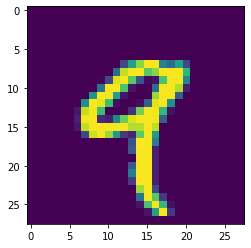

In [521]:
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [533]:
d=[0,0,0,0,0,0,2]
e = tf.reduce_max(d).numpy()
f = tf.equal(e, d)
print(d)
print(e)
print(f)
print(tf.argmax(d).numpy())

[0, 0, 0, 0, 0, 0, 2]
2
tf.Tensor([False False False False False False  True], shape=(7,), dtype=bool)
6


# Define and Train Model

## Definiton of MLP DNN

In [3]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu', input_shape=(784)):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='weight'
                                )
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False,
                                    name='mask'
                                   )
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False,
                                 name='pruned_weights'
                                )

   
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print('layer inputy', inputs.shape)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        if self.activation == None:
            return x
            
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300, input_shape=(None, 784))
        self.dense2 = CustomLayer(100, input_shape=(None, 300))
        self.dense3 = CustomLayer(10, activation=None, input_shape=(None, 100))
        
    def call(self, inputs):
        #print('NN call',inputs.shape)
        x = tf.keras.layers.Flatten()(inputs)
        x = self.dense1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        self.pre_softmax = x
        return tf.keras.activations.softmax(x)
        #return x
    


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255


In [5]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

In [6]:
def initialize_model():
    model = LeNet300_100()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )
    return model

def train_model(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=data.train,
              #batch_size=64,
              epochs=500,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )


In [7]:
model = initialize_model()
train_model(model)

Epoch 1/500
    469/Unknown - 16s 35ms/step - loss: 1.6599 - accuracy: 0.7375Epoch 1/500
469/469 [==============================] - 17s 36ms/step - loss: 1.6598 - accuracy: 0.7378 - val_loss: 1.6017 - val_accuracy: 0.8624
Epoch 2/500
469/469 [==============================] - 13s 28ms/step - loss: 1.5374 - accuracy: 0.9015 - val_loss: 1.5130 - val_accuracy: 0.9494
Epoch 3/500
469/469 [==============================] - 14s 29ms/step - loss: 1.5046 - accuracy: 0.9568 - val_loss: 1.4986 - val_accuracy: 0.9647
Epoch 4/500
469/469 [==============================] - 15s 33ms/step - loss: 1.4951 - accuracy: 0.9677 - val_loss: 1.4975 - val_accuracy: 0.9655
Epoch 5/500
469/469 [==============================] - 17s 36ms/step - loss: 1.4892 - accuracy: 0.9711 - val_loss: 1.4945 - val_accuracy: 0.9681
Epoch 6/500
469/469 [==============================] - 15s 33ms/step - loss: 1.4856 - accuracy: 0.9746 - val_loss: 1.4896 - val_accuracy: 0.9723
Epoch 7/500
469/469 [==============================] 